In [24]:
import os
import numpy as np

In [2]:
## list with all the files 
pathtowav = '/media/nfarrugi/Expansion/EcoHack/Chunks/'
chunklist = os.listdir(pathtowav)

In [3]:
goodfiles = []

for curfile in chunklist:
    splitted = curfile.split('_')
    
    if (os.path.splitext(curfile)[1] == '.wav') and (splitted[-2]!='3s'):
        goodfiles.append(curfile)

In [4]:
import pandas as pd 

labelsfile = '20221101_120529UTC_summary.txt'

In [5]:
from torchaudio import info,load
from librosa import get_samplerate,get_duration

In [6]:
wav,sr = load(os.path.join(pathtowav,goodfiles[0]))

In [7]:
print(f"Duration of file {goodfiles[0]} is {wav.shape[1] / sr} seconds")

Duration of file 20210418_184500.loc01_00;33-00;36_(type_1).wav is 3.0 seconds


In [8]:
len(goodfiles)

5190

In [9]:
Df = pd.read_csv(os.path.join(pathtowav,labelsfile),names=['origpath','call1','call2','call3','call4'])

In [10]:
Df['wav'] = [curpath[49:] for curpath in Df['origpath']]

In [11]:
from panns_inference import AudioTagging

In [12]:
Df['wav']

0       20210418_184500.loc01_01;42-01;45_(type_1).wav
1       20210418_184500.loc01_02;42-02;45_(type_2).wav
2       20210418_184500.loc01_02;45-02;48_(type_2).wav
3       20210418_184500.loc01_02;48-02;51_(type_2).wav
4       20210418_184500.loc01_02;51-02;54_(type_2).wav
                             ...                      
5133                  XC84221_00;30-00;33_(type_3).wav
5134                  XC84221_00;33-00;36_(type_3).wav
5135                  XC84221_00;36-00;39_(type_3).wav
5136                  XC84221_00;06-00;09_(type_3).wav
5137                  XC84221_00;09-00;12_(type_3).wav
Name: wav, Length: 5138, dtype: object

In [13]:
recorders = [curstring.split('loc') for curstring in Df['wav']]

loc01 -> recorder 1

loc1 ->recorder 1 

loc4B -> recorder 2 

loc8B -> recorder 3 

loc10 -> recorder 4 

AM02 -> recorder 5

In [14]:
rec_dict ={'01':1,'1_':1,'4B':2,'8B':3,'10':4,'30':5,'null':6}

In [15]:
rec_id = []
for currec in recorders:
    if len(currec)==1:
        rec_id.append(rec_dict['null'])
    else:
        rec_id.append(rec_dict[currec[1][:2]])
    

In [16]:
Df['recorder_id']=rec_id

In [17]:
allsamplerates = []
waves_32k = []
labels = []
recorders_id = []
for curfile in goodfiles:
    meta = info((os.path.join(pathtowav,curfile)))
    sr = meta.sample_rate
    allsamplerates.append(sr)
    if sr == 32000.0:
        curwave = load(os.path.join(pathtowav,curfile))[0]
        if curwave.shape[1]==96000 and len(Df[Df['wav'] == curfile])!=0 :
            waves_32k.append(curwave)
            recorders_id.append(Df[Df['wav'] == curfile]['recorder_id'].iloc[0])
            if (Df[Df['wav'] == curfile]['call1'].iloc[0])==1:
                labels.append(1)
            elif (Df[Df['wav'] == curfile]['call2'].iloc[0])==1:
                labels.append(2)
            elif (Df[Df['wav'] == curfile]['call3'].iloc[0])==1:
                labels.append(3)
            elif (Df[Df['wav'] == curfile]['call4'].iloc[0])==1:
                labels.append(4)
            

In [18]:
import torch 
waves_32k = torch.vstack(waves_32k)

In [19]:
waves_32k.shape

torch.Size([1764, 96000])

In [20]:
len(labels)

1764

In [21]:
tagging = AudioTagging(device='cpu')

Checkpoint path: /home/nfarrugi/panns_data/Cnn14_mAP=0.431.pth
Using CPU.


In [22]:
_, embeddings = tagging.inference(waves_32k[:500])
_, embeddings2 = tagging.inference(waves_32k[500:1000])
_, embeddings3 = tagging.inference(waves_32k[1000:])

In [25]:
embeddings=np.vstack([embeddings,embeddings2,embeddings3])

In [26]:
from sklearn.manifold import TSNE
from umap import UMAP

In [27]:
decomp = UMAP(n_components=2)

In [28]:
emb_2d = decomp.fit_transform(embeddings)

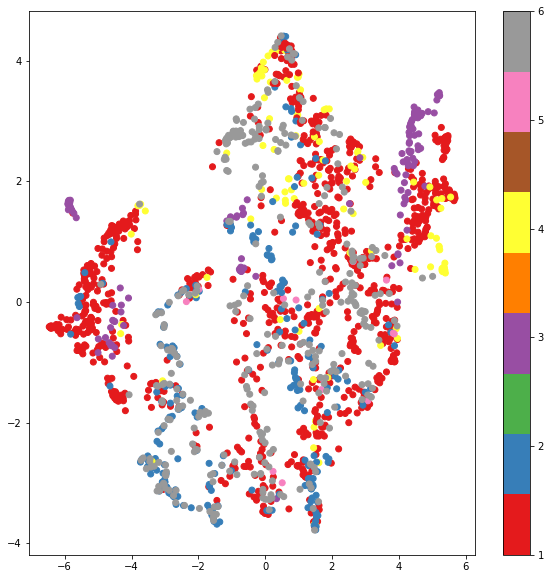

In [29]:
from matplotlib import pyplot as plt 

fig = plt.figure(figsize=(10,10))

plt.scatter(emb_2d[:,0],emb_2d[:,1],c=recorders_id,cmap=plt.cm.Set1)
plt.colorbar()

In [30]:
from sklearn.model_selection import train_test_split

In [31]:
x_train,x_test,y_train,y_test = train_test_split(embeddings,labels,train_size=0.8)

In [33]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.multiclass import OneVsRestClassifier

In [34]:
clf = OneVsRestClassifier(RandomForestClassifier())

In [35]:
clf.fit(x_train,y_train)

OneVsRestClassifier(estimator=RandomForestClassifier())

In [36]:
y_pred_train = clf.predict(x_train)

In [37]:
y_pred = clf.predict(x_test)

In [38]:
from sklearn.metrics import classification_report

In [39]:
print(classification_report(y_train,y_pred_train))

              precision    recall  f1-score   support

           1       1.00      1.00      1.00       835
           2       1.00      1.00      1.00       290
           3       1.00      1.00      1.00        26
           4       1.00      0.99      1.00       260

    accuracy                           1.00      1411
   macro avg       1.00      1.00      1.00      1411
weighted avg       1.00      1.00      1.00      1411



In [40]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           1       0.80      0.91      0.86       221
           2       0.82      0.55      0.66        74
           3       1.00      0.20      0.33        10
           4       0.46      0.48      0.47        48

    accuracy                           0.76       353
   macro avg       0.77      0.54      0.58       353
weighted avg       0.77      0.76      0.75       353



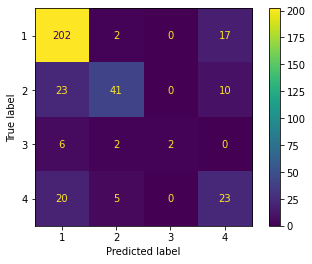

In [41]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [ ]:
from sklearn.model_selection import permutation_test_score

In [ ]:
score, permutations, pvalue = permutation_test_score(X=embeddings,y=labels,cv=5,estimator=clf,scoring='precision',n_permutations=100)